# Bank Marketing Analysis

![title](rawpixel-594763-unsplash.jpg)

*Photo by rawpixel on __[Unsplash](https://unsplash.com)__*

In [1]:
#import linear algebra and data manipulation libraries
import numpy as np
import pandas as pd

#import standard visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from plotly import tools

# plotly and cufflinks in offline mode
import cufflinks as cf
cf.go_offline(connected=True)
init_notebook_mode(connected=True)

In [3]:
#import machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import accuracy_score #metrics

#tools for hyperparameters search
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Introduction

Today organizations, which hire data scientists are especially interested in job candidate's portfolio. Analysis of organization's marketing data is one of the most typical applications of data science and machine learning. Such analysis will definetely be a nice contribution to the protfolio.

In general, datasets which contain marketing data can be used for 2 different business goals:
1. Prediction of the results of the marketing campaign for each customer and clarification of factors which affect the campaign results. This helps to find out the ways how to make marketing campaigns more efficient.
2. Finding out customer segments, using data for customers, who subscribed to term deposit. This helps to identify the profile of a customer, who is more likely to acquire the product and develop more targeted marketing campaigns.

There is a __[dataset, which contains bank marketing data on Kaggle](https://www.kaggle.com/janiobachmann/bank-marketing-dataset)__. This dataset contains banking marketing campaign data and we can use it to optimize marketing campaigns to attract more customers to term deposit subscription.
<br> Detailed description of the dataset's content is describe in this __[Kaggle kernel](https://www.kaggle.com/janiobachmann/marketing-in-banking-opening-term-deposits)__.

## Approach

In order to optimize marketing campaigns with the help of the dataset, we will have to take the following steps:
1. Import data from dataset and perform initial high-level analysis: look at the number of rows, look at the missing values, look at dataset columns and their values respective to the campaign outcome.
2. Clean the data: remove irrelevant columns, deal with missing and incorrect values, turn categorical columns into dummy variables.
3. Use machine learning techniques to predict the marketing campaign outcome and to find out factors, which affect the success of the campaign.

## Import Data

First of all to perform the analysis, we have to import the data:

In [4]:
#import dataset

df = pd.read_csv('bank.csv')

In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


Each feature is described in __[this kernel](https://www.kaggle.com/janiobachmann/marketing-in-banking-opening-term-deposits)__ on Kaggle.

## Data Exploration

After we imported the dataset, we have to look at the total number of rows in the dataset and analyze the number of missing values.

In [6]:
# number of rows in dataset

print("Bank marketing dataset consists of {rows} rows.".format(rows = len(df)))

Bank marketing dataset consists of 11162 rows.


Analyze number of missing values for each column:

In [7]:
#find percentage of missing values for each column
missing_values = df.isnull().mean()*100

missing_values.sum()

0.0

So we see that there are no missing values.

Explore dataset columns:

### Categorical columns exploration

In the dataset we have both categorical and numerical columns. Let's look at the values of categorical columns first.

In [8]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig = tools.make_subplots(rows=3, cols=3, subplot_titles = cat_columns)
counter = 0

for cat_column in cat_columns:
    value_counts = df[cat_column].value_counts()
    
    trace = go.Bar(
            x= value_counts.index,
            y= value_counts.values,
            name = cat_column
    )
    
    trace_x = counter // 3 + 1
    trace_y = counter % 3 + 1
    
    fig.append_trace(trace, trace_x, trace_y)
    
    counter += 1
    
fig['layout'].update(height=850, width=1000, title='Categorical columns values')
py.iplot(fig, filename='categorical_columns_values')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



/Users/aleksandraastakhova/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



### Numerical columns exploration

Now let's look at the numerical columns' values. The most convenient way to look at the numerical values is plotting histograms.

In [9]:
df_num = df[['balance', 'day','duration', 'campaign', 'pdays', 'previous']]

cf.set_config_file(offline=False, world_readable=True, theme='pearl')

df_num.iplot(kind='histogram', subplots=True, shape=(3, 2), bins= 30, filename='numerical_columns_values',
             title = 'Numerical columns values')

We can see that numerical columns have outliers (especially 'pdays', 'campaign' and 'previous' columns). Possibly there are incorrect values (noisy data), so we should look closer at the data and decide how do we manage the noise.

Let's look closer at the values of 'campaign', 'pdays' and 'previous' columns:

In [10]:
df[['pdays', 'campaign', 'previous']].describe()

,pdays,campaign,previous
count,11162.000000,11162.000000,11162.000000
mean,51.330407,2.508421,0.832557
std,108.758282,2.722077,2.292007
min,-1.000000,1.000000,0.000000
25%,-1.000000,1.000000,0.000000
50%,-1.000000,2.000000,0.000000
75%,20.750000,3.000000,1.000000
max,854.000000,63.000000,58.000000


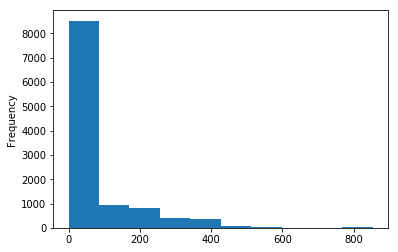

In [11]:
df['pdays'].plot.hist()

Percentage of 'pdays' values above 200:

In [12]:
len (df[df['pdays'] > 200] ) / len(df) * 100

9.12022934957893

Percentage of 'pdays' values above 300:

In [13]:
len (df[df['pdays'] > 300] ) / len(df) * 100

5.81437018455474

Percentage of 'pdays' values above 400:

In [14]:
len (df[df['pdays'] > 400] ) / len(df) * 100

1.2005017022039062

'pdays' holds
the number of days that passed by after the client was last contacted from a previous campaign
Looking closer into 'pdays' data we can see that:
* only 1.2% of values above 400. They are possibly outliers, so we should consider imputing something (possibly mean value) instead of these values.
* -1 possibly means that the client wasn't contacted before or stands for missing data.

Since we are not sure exactly what -1 means I suggest to drop this column, because -1 makes more than 50% of the values of the column.

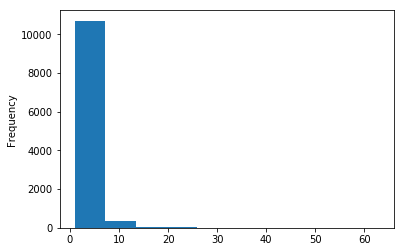

In [15]:
df['campaign'].plot.hist()

Percentage of 'campaign' values above 20:

In [16]:
len (df[df['campaign'] > 34] ) / len(df) * 100

0.035835871707579285

'campaign' holds the number of contacts performed during this campaign and for this client (numeric, includes last contact)
Numbers for 'campaign' above 34 are clearly noise, so I suggest to impute them with average campaign values while data cleaning.

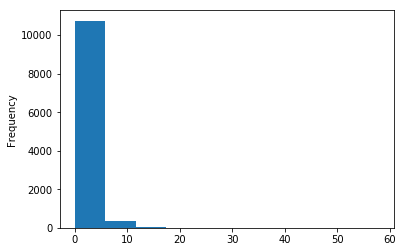

In [17]:
df['previous'].plot.hist()

In [18]:
len (df[df['previous'] > 34] ) / len(df) * 100

0.04479483963447411

'previous' holds the number of contacts performed before this campaign and for this client (numeric)
Numbers for 'previous' above 34 are also really strange, so I suggest to impute them with average campaign values while data cleaning.

### Analysis of the response column

It is very important to look at the response column, which holds the information, which we are going to predict. In our case we should look at 'deposit' column and compare its values to other columns. 

First of all we should look at the number of 'yes' and 'no' values in the response column 'deposit'.

In [ ]:
value_counts = df['deposit'].value_counts()

data = [
    go.Bar(
        x=value_counts.index,
        y=value_counts.values,
        name = 'deposit'
    )
]

layout = go.Layout(
    title='Deposit values',
    height=300, width=600,
    xaxis=dict(
        title='Deposit',
        titlefont=dict(
            size=16,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Value counts',
        titlefont=dict(
            size=16,
            color='#7f7f7f'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='deposit_bar_chart')

On the diagram we see that counts for 'yes' and 'no' values for 'deposit' are close, so we can use accuracy as a metric for a model, which predicts the campaign outcome.

Let's see how 'deposit' column value variesdepending on other categorical columns' values:

In [ ]:
#job and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['job'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['job'].value_counts()

j_df.iplot(kind = 'bar', title = 'Job and deposit')

In [ ]:
#marital status and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['marital'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['marital'].value_counts()

j_df.iplot(kind = 'bar', title = 'Marital status and deposit')

In [ ]:
#education and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['education'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['education'].value_counts()

j_df.iplot(kind = 'bar', title = 'Education and deposit')

In [ ]:
#type of contact and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['contact'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['contact'].value_counts()

j_df.iplot(kind = 'bar', title = 'Type of contact and deposit')

Regarding the diagrams we can tell that according to our dataset:
1. Customers with 'blue-collar' and 'services' jobs are less likely to subscribe for term deposit.
2. Married customers are less likely to subscribe for term deposit.
3. Customers with 'cellular' type of contact are less likely to subscribe for term deposit.

Now let's look how numerical columns affect term deposit subscription.

In [ ]:
#balance and deposit

b_df = pd.DataFrame()
b_df['balance_yes'] = (df[df['deposit'] == 'yes'][['deposit','balance']].describe())['balance']
b_df['balance_no'] = (df[df['deposit'] == 'no'][['deposit','balance']].describe())['balance']

b_df

,balance_yes,balance_no
count,5289.000000,5873.000000
mean,1804.267915,1280.227141
std,3501.104777,2933.411934
min,-3058.000000,-6847.000000
25%,210.000000,64.000000
50%,733.000000,414.000000
75%,2159.000000,1324.000000
max,81204.000000,66653.000000


In [ ]:
b_df.drop(['count', '25%', '50%', '75%']).iplot(kind = 'bar', title = 'Balance and deposit statistics')

In [ ]:
#age and deposit

a_df = pd.DataFrame()
a_df['age_yes'] = (df[df['deposit'] == 'yes'][['deposit','age']].describe())['age']
a_df['age_no'] = (df[df['deposit'] == 'no'][['deposit','age']].describe())['age']

a_df

,age_yes,age_no
count,5289.000000,5873.000000
mean,41.670070,40.837391
std,13.497781,10.264815
min,18.000000,18.000000
25%,31.000000,33.000000
50%,38.000000,39.000000
75%,50.000000,48.000000
max,95.000000,89.000000


In [ ]:
a_df.drop(['count', '25%', '50%', '75%']).iplot(kind = 'bar', title = 'Age and deposit statistics')

In [ ]:
#number of contacts performed during this campaign ('campaign') and deposit

In [ ]:
c_df = pd.DataFrame()
c_df['campaign_yes'] = (df[df['deposit'] == 'yes'][['deposit','campaign']].describe())['campaign']
c_df['campaign_no'] = (df[df['deposit'] == 'no'][['deposit','campaign']].describe())['campaign']

c_df

,campaign_yes,campaign_no
count,5289.000000,5873.000000
mean,2.141047,2.839264
std,1.921826,3.244474
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,32.000000,63.000000


In [ ]:
c_df.drop(['count', '25%', '50%', '75%']).iplot(kind = 'bar', title = 'Number of contacts performed during this campaign and deposit statistics')

In [ ]:
#number of contacts performed during previous campaign ('previous') and deposit

In [ ]:
p_df = pd.DataFrame()
p_df['previous_yes'] = (df[df['deposit'] == 'yes'][['deposit','previous']].describe())['previous']
p_df['previous_no'] = (df[df['deposit'] == 'no'][['deposit','previous']].describe())['previous']

p_df

,previous_yes,previous_no
count,5289.000000,5873.00000
mean,1.170354,0.52835
std,2.553272,1.97961
min,0.000000,0.00000
25%,0.000000,0.00000
50%,0.000000,0.00000
75%,1.000000,0.00000
max,58.000000,41.00000


In [ ]:
p_df.drop(['count', '25%', '50%', '75%']).iplot(kind = 'bar', title = 'Number of contacts performed during previous campaign and deposit statistics')

Looking at the diagrams above we can conclude that:
1. People who subscribed for term deposit tend to have greater balance and age values.
2. People who subscribed for term deposit tend to have fewer number of contacts during this campaign.

## Data Cleaning

Before we will be able to apply machine learning techniques, we should prepare the dataset for processing:
1. Convert columns with 'yes' and 'no' values to boolean columns;
2. Convert categorical columns into dummy variables.

In [ ]:
def get_dummy_from_bool(row, column_name):
    ''' Returns 0 if value in column_name is no, returns 1 if value in column_name is yes'''
    return 1 if row[column_name] == 'yes' else 0

def get_correct_values(row, column_name, threshold, df):
    ''' Returns mean value if value in column_name is above threshold'''
    if row[column_name] <= threshold:
        return row[column_name]
    else:
        mean = df[df[column_name] <= threshold][column_name].mean()
        return mean

def clean_data(df):
    '''
    INPUT
    df - pandas dataframe containing bank marketing campaign dataset
    
    OUTPUT
    df - cleaned dataset:
    1. columns with 'yes' and 'no' values are converted into boolean variables;
    2. categorical columns are converted into dummy variables;
    3. drop irrelevant columns.
    4. impute incorrect values
    '''
    
    cleaned_df = df.copy()
    
    #convert columns containing 'yes' and 'no' values to boolean variables and drop original columns
    bool_columns = ['default', 'housing', 'loan', 'deposit']
    for bool_col in bool_columns:
        cleaned_df[bool_col + '_bool'] = df.apply(lambda row: get_dummy_from_bool(row, bool_col),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = bool_columns)
    
    #convert categorical columns to dummies
    cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
    
    for col in  cat_columns:
        cleaned_df = pd.concat([cleaned_df.drop(col, axis=1),
                                pd.get_dummies(cleaned_df[col], prefix=col, prefix_sep='_',
                                               drop_first=True, dummy_na=False)], axis=1)
    
    #drop irrelevant columns
    cleaned_df = cleaned_df.drop(columns = ['pdays'])
    
    #impute incorrect values and drop original columns
    cleaned_df['campaign_cleaned'] = df.apply(lambda row: get_correct_values(row, 'campaign', 34, cleaned_df),axis=1)
    cleaned_df['previous_cleaned'] = df.apply(lambda row: get_correct_values(row, 'previous', 34, cleaned_df),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = ['campaign', 'previous'])
    
    return cleaned_df

In [ ]:
#clean the dataset
cleaned_df = clean_data(df)
cleaned_df.head()

,age,balance,day,duration,default_bool,housing_bool,loan_bool,deposit_bool,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,campaign_cleaned,previous_cleaned
0,59,2343,5,1042,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
1,56,45,5,1467,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
2,41,1270,5,1389,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
3,55,2476,5,579,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
4,54,184,5,673,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,2.0,0.0


## Machine Learning for prediction of campaign outcome

### Classification model for the campaign outcome prediction

Now let's use cleaned datasets for prediction of campaign outcome with help of machine learning classification models. I will use __[XGBoost](https://xgboost.readthedocs.io/en/latest/)__, which is one of the most common machine learning libraries for modelling.
<br> Resulting model will also help me to understand, which features have the greatest importance for the prediction of the results of the campaing.

Create X and y datasets for training the model and split into train and test datasets.

In [ ]:
X = cleaned_df.drop(columns = 'deposit_bool')
y = cleaned_df[['deposit_bool']]

In [ ]:
TEST_SIZE = 0.3
RAND_STATE = 42

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

Train XGBoost classifier model:

In [ ]:
#train XGBoost model
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train.squeeze().values)

#calculate and print scores for the model for top 15 features
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('XGB accuracy score for train: %.3f: test: %.3f' % (
        accuracy_score(y_train, y_train_preds),
        accuracy_score(y_test, y_test_preds)))

XGB accuracy score for train: 0.911: test: 0.848


Get the feature importances from the trained model:

In [ ]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances
trace1 = go.Bar(x=xgb_feature_importances['name'],
                y=xgb_feature_importances['score'])
                                               
data=go.Data([trace1])
layout=go.Layout(title="Feature Importances (XGB)", yaxis={'title':'scores'})
figure=go.Figure(data=data,layout=layout)
py.iplot(figure, filename='feature_importances')

/Users/aleksandraastakhova/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:39: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




As we can see from the diagram showing feature importances, the most important features are:
* Customer's account balance,
* Customer's age,
* Number of contacts performed during this campaign and contact duration,
* Number of contacts performed before this campaign.

So the main outcomes of the modelling are:
* Customers of greater age are more likely to subscribe for the term deposit.
* Customers with greater account balance are more likely to subscribe for the term deposit.
* Number of contacts with the customers really matters. Too many contacts with the customer could make him decline the offer.

Let's try to make more specific recommendations:

1. Find out account balance, which marketing campaign should focus on: 

In [ ]:
df_new = cleaned_df.copy()

#introduce new column 'balance_buckets' to  ''
df_new['balance_buckets'] = pd.qcut(df_new['balance'], 50, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_deposit = df_new.groupby(['balance_buckets'])['deposit_bool'].mean()

#plot average campaign outcome per bucket 
trace = go.Scatter(
    x = mean_deposit.index,
    y = mean_deposit.values,
    mode = 'lines'
)
data = [trace]
layout=go.Layout(title="Average outcome depending on balance", yaxis={'title':'average outcome'},
                 xaxis={'title':'balance bucket'})
figure=go.Figure(data=data,layout=layout)
py.iplot(figure, filename='balance-buckets-scatter')

In [ ]:
df_new[df_new['balance_buckets'] == 34]['balance'].min()

1490

From the diagram above we can conclude, that marketing campaigns should concentrate on customers with account balance greater than 1490$.

2. Find out what customers age campaign should focus on:

In [ ]:
#introduce new column 'age_buckets' to  ''
df_new['age_buckets'] = pd.qcut(df_new['age'], 20, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_age = df_new.groupby(['age_buckets'])['deposit_bool'].mean()

#plot average campaign outcome per bucket 
trace = go.Scatter(
    x = mean_age.index,
    y = mean_age.values,
    mode = 'lines'
)
data = [trace]
layout=go.Layout(title="Average outcome depending on age", yaxis={'title':'average outcome'},
                 xaxis={'title':'age bucket'})
figure=go.Figure(data=data,layout=layout)
py.iplot(figure, filename='age-buckets-scatter')

In [ ]:
df_new[df_new['age_buckets'] == 3]['age'].max()

31

In [ ]:
df_new[df_new['age_buckets'] == 17]['age'].min()

56

3. Find out appropriate number of contacts with the customer during campaign:

In [ ]:
#introduce new column 'age_buckets' to  ''
df_new['campaign_buckets'] = pd.qcut(df_new['campaign_cleaned'], 20, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_campaign = df_new.groupby(['campaign_buckets'])['deposit_bool'].mean()

#plot average campaign outcome per bucket 
trace = go.Scatter(
    x = mean_campaign.index,
    y = mean_campaign.values,
    mode = 'lines'
)
data = [trace]
layout=go.Layout(title="Average outcome depending on number of calls during campaign", 
                 yaxis={'title':'average outcome'},
                 xaxis={'title':'campaign bucket'})
figure=go.Figure(data=data,layout=layout)
py.iplot(figure, filename='campaign-buckets-scatter')

In [ ]:
df_new[df_new['campaign_buckets'] == 2]['campaign_cleaned'].min()

4.0

### Model Stacking for accuracy improvement

Common technique which is used to raise accuracy of models is model stacking. This technique combines information from several models to create a new model. See __[this article](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/)__ for more details and examples of this technique.
<br> I used code from this __[Kaggle kernel](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)__ to implement model stacking.

In [ ]:
"""

Class to wrap the Sklearn classifier in order to pass different
classifiers to folding function
 
"""
class SklearnHelper(object):
    """ 
    Init function
    
    INPUT
        clf - sklearn classifier
        seed - random seed
        params - dictionary containing parameters for the classifier clf
    """
    def __init__(self, clf, seed=42, params=None):
        #params['random_state'] = seed
        self.clf = clf(**params)

    """
    Wrapper for train function
    
    INPUT
        x_train - training set
        y_train - response vector for the training set
        
    RETURNS
        trained model
    """
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    """
    Wrapper for predict function
    
    INPUT
        x - training set
        
    RETURNS
        predicted response vector for x
    """
    def predict(self, x):
        return self.clf.predict(x)
    
    """
    Wrapper for feature impornaces function
    
    INPUT
        x - training set
        y  - response vector for the training set
        
    RETURNS
        feature importances for trained model using x and y
    """
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [ ]:
from sklearn.model_selection import KFold #import folding from sklearn

""" Number of folds """
NFOLDS = 5

""" Random seed for folding """
SEED = 42

"""
Function, which performs out of fold train and test predictions, 
which will be used as new variables for stacking models.

INPUT
    clf - warpped sklearn classifier
    x_train - training dataset
    y_train - response vector for training dataset
    x_test - test dataset
    n_folds - number of folds for stacking
    seed - random seed

"""
def get_oof(clf, x_train, y_train, x_test, nfolds = NFOLDS, seed = SEED):
    arg = {'n_splits':nfolds, 'random_state':seed}
    kf = KFold( **arg)
    
    
    oof_train = np.zeros((x_train.shape[0],))
    oof_test = np.zeros((x_test.shape[0],))
    oof_test_skf = np.empty((nfolds, x_test.shape[0]))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.iloc[train_index]
        y_tr = y_train[train_index]
        x_te = x_train.iloc[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

Let's train couple of different classification models and combine their results for a level-2 model:

1. Random Forest Classifier:

In [ ]:
#define Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

#initialize helper class
rf = SklearnHelper(clf=RandomForestClassifier, seed=42, params=rf_params)

In [ ]:
#perform oof training
rf_oof_train, rf_oof_test = get_oof(rf, X_train, y_train.squeeze().values, X_test) # Random Forest

2. AdaBoost Classifier:

In [ ]:
# define AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

#initialize helper class
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)

In [ ]:
#perform oof training
ada_oof_train, ada_oof_test = get_oof(ada, X_train, y_train.squeeze().values, X_test) # AdaBoost

3. Gradient Boosting classifier

In [ ]:
# define Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

In [ ]:
#initialize helper class
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)

In [ ]:
gb_oof_train, gb_oof_test = get_oof(gb, X_train, y_train.squeeze().values, X_test) 

4. SVM Classifier

In [ ]:
# define Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [ ]:
#initialize helper class
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [ ]:
svc_oof_train, svc_oof_test = get_oof(svc, X_train, y_train.squeeze().values, X_test)

5. KNN Classifier

In [ ]:
#define KNN parameters
knn_params = {
    'n_neighbors': 3
    }

In [ ]:
#initialize helper class
knn = SklearnHelper(clf=KNeighborsClassifier, seed=SEED, params=knn_params)

In [ ]:
knn_oof_train, knn_oof_test = get_oof(knn, X_train, y_train.squeeze().values, X_test)

6. Naive Bayes Classifier

In [ ]:
#define Naive Bayes parameters
nb_params = {
    'var_smoothing' : 1e-09
    }

In [ ]:
#initialize helper class
nb = SklearnHelper(clf=GaussianNB, seed=SEED, params=nb_params)

In [ ]:
nb_oof_train, nb_oof_test = get_oof(nb, X_train, y_train.squeeze().values, X_test)

Concatenate the results of level-1 models

In [ ]:
X_train_level2 = np.concatenate(( rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train, knn_oof_train, nb_oof_train), axis=1)
X_test_level2 = np.concatenate(( rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test, knn_oof_test, nb_oof_test), axis=1)

Use XGBoost classifier as level 2 model and predict the results:

In [ ]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 2, 3, 5, 10],
        'gamma': [0.5, 0.7, 0.8, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [2, 3, 4, 5, 6 ,7],
        'n_estimators': [100, 200, 300, 400, 500]
        }

In [ ]:
gbm = xgboost.XGBClassifier(
 learning_rate = 0.02,
 n_estimators= 500,
 max_depth= 4,
 min_child_weight= 2,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)

In [ ]:
folds = 3
param_comb = 300

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = SEED)

random_search = RandomizedSearchCV(gbm, 
                                   param_distributions=params, 
                                   n_iter=param_comb, 
                                   scoring='accuracy', n_jobs=4, cv=skf.split(X_train_level2, y_train), verbose=3, 
                                   random_state=1001 )

random_search.fit(X_train, y_train)

In [ ]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

In [ ]:
gbm_best = xgboost.XGBClassifier(
 learning_rate = 0.02,
 n_estimators= 500,
 max_depth= 7,
 min_child_weight= 1,
 gamma= 5,                        
 subsample=0.8,
 colsample_bytree= 1.0,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)

gbm_best.fit(X_train_level2, y_train)

y_train_preds = gbm_best.predict(X_train_level2)
y_test_preds = gbm_best.predict(X_test_level2)

print('XGB-level2 accuracy score for train: %.3f test: %.3f' % (
        accuracy_score(y_train, y_train_preds),
        accuracy_score(y_test, y_test_preds)))

As we can see resulting level-2 model outperforms the initial model:
* Accuracy score on testing dataset is slightly greater.
* Accuracy score on training dataset is slightly lower, it means that resulting level-2 model is less likely to be overfitted.

## Conclusion

Key outcomes of the analysis are the recommendations for future marketing campaigns:
* The customer's account balance has a huge influence on the campaign's outcome. People with account balance above 1490$ are more likely to subscribe for term deposit, so future address those customers.
* The customer's age affects campaign outcome as well. Future campains should concentrate on customers from age categories below 30 years old and above 50 years old.
* Number of contacts with the customer during the campaign is also very important. The number of contacts with the customer shouldn't exceed 4.